# Data preparation

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import joblib
warnings.filterwarnings("ignore")

In [35]:
data = "machine_failure.csv"

In [36]:
df = pd.read_csv(data)

# EDA

In [37]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1000,308.6000,1551,42.8000,0,0,0,0,0,0,0
1,2,L47181,L,298.2000,308.7000,1408,46.3000,3,0,0,0,0,0,0
2,3,L47182,L,298.1000,308.5000,1498,49.4000,5,0,0,0,0,0,0
3,4,L47183,L,298.2000,308.6000,1433,39.5000,7,0,0,0,0,0,0
4,5,L47184,L,298.2000,308.7000,1408,40.0000,9,0,0,0,0,0,0


In [38]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [39]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [40]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000
mean,5000.5000,300.0049,310.0056,1538.7761,39.9869,107.9510,0.0339,0.0046,0.0115,0.0095,0.0098,0.0019
std,2886.8957,2.0003,1.4837,179.2841,9.9689,63.6541,0.1810,0.0677,0.1066,0.0970,0.0985,0.0435
min,1.0000,295.3000,305.7000,1168.0000,3.8000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,2500.7500,298.3000,308.8000,1423.0000,33.2000,53.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,5000.5000,300.1000,310.1000,1503.0000,40.1000,108.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,7500.2500,301.5000,311.1000,1612.0000,46.8000,162.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,10000.0000,304.5000,313.8000,2886.0000,76.6000,253.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [41]:
df.columns = df.columns.str.strip().str.replace(' ','_').str.lower()

In [42]:
df.head()

,udi,product_id,type,air_temperature_[k],process_temperature_[k],rotational_speed_[rpm],torque_[nm],tool_wear_[min],machine_failure,twf,hdf,pwf,osf,rnf
0,1,M14860,M,298.1000,308.6000,1551,42.8000,0,0,0,0,0,0,0
1,2,L47181,L,298.2000,308.7000,1408,46.3000,3,0,0,0,0,0,0
2,3,L47182,L,298.1000,308.5000,1498,49.4000,5,0,0,0,0,0,0
3,4,L47183,L,298.2000,308.6000,1433,39.5000,7,0,0,0,0,0,0
4,5,L47184,L,298.2000,308.7000,1408,40.0000,9,0,0,0,0,0,0


In [43]:
X = df.drop(columns=["machine_failure", "udi", "product_id"], axis=1)
y = df["machine_failure"]

In [44]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = ["type"]

In [45]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    verbose_feature_names_out=False
)

In [46]:
y = y.astype(int)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [48]:
## Target distribution

y.value_counts(normalize=True)

machine_failure
0   0.9661
1   0.0339
Name: proportion, dtype: float64

In [49]:
## Feature importance analysis

X_enc = pd.get_dummies(X, drop_first=True)

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)
rf.fit(X_enc, y)

importances = pd.Series(
    rf.feature_importances_,
    index=X_enc.columns
).sort_values(ascending=False)

importances.head(10)

hdf                       0.2835
osf                       0.2118
pwf                       0.1773
twf                       0.1170
torque_[nm]               0.0799
rotational_speed_[rpm]    0.0557
tool_wear_[min]           0.0330
air_temperature_[k]       0.0207
process_temperature_[k]   0.0160
type_L                    0.0029
dtype: float64

In [50]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [51]:
binary_classification = len(np.unique(y)) == 2
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, average="weighted", zero_division=0),
    "recall": make_scorer(recall_score, average="weighted", zero_division=0),
    "f1": make_scorer(f1_score, average="weighted", zero_division=0)
}
if binary_classification:
    scoring["roc_auc"] = make_scorer(roc_auc_score, needs_proba=True)

In [52]:
xgb_pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    ))
])

xgb_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.05, 0.1],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0]
}


In [53]:
models_and_grids = {
    "Logistic Regression": {
        "estimator": Pipeline([
            ("prep", preprocessor),
            ("clf", LogisticRegression(max_iter=1000))
        ]),
        "param_grid": {
            "clf__C": [0.01, 0.1, 1, 10]
        }
    },

    "Decision Tree": {
        "estimator": Pipeline([
            ("prep", preprocessor),
            ("clf", DecisionTreeClassifier(random_state=42))
        ]),
        "param_grid": {
            "clf__max_depth": [None, 5, 10, 20],
            "clf__min_samples_split": [2, 5, 10]
        }
    },

    "Random Forest": {
        "estimator": Pipeline([
            ("prep", preprocessor),
            ("clf", RandomForestClassifier(random_state=42))
        ]),
        "param_grid": {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20]
        }
    },

    "XGBoost": {
        "estimator": xgb_pipeline,
        "param_grid": xgb_param_grid
    },
}


In [54]:
results = []
best_models = {}

for name, entry in models_and_grids.items():
    print(f"\n--- Tuning {name} ---")

    grid = GridSearchCV(
        estimator=entry["estimator"],
        param_grid=entry["param_grid"],
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best = grid.best_estimator_
    best_models[name] = best

    y_pred = best.predict(X_test)
    y_prob = best.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Best params": grid.best_params_,
        "Test ROC-AUC": roc_auc_score(y_test, y_prob),
        "Test F1": f1_score(y_test, y_pred),
        "Test Accuracy": accuracy_score(y_test, y_pred)
    })


--- Tuning Logistic Regression ---

--- Tuning Decision Tree ---

--- Tuning Random Forest ---

--- Tuning XGBoost ---


In [55]:
results_df = pd.DataFrame(results).sort_values(by="Test ROC-AUC", ascending=False).reset_index(drop=True)
pd.set_option('display.float_format', lambda x: f"{x:.4f}")
print("\nFinal comparison (sorted by Test accuracy):\n")
print(results_df)


Final comparison (sorted by Test accuracy):

                 Model                                        Best params  \
0              XGBoost  {'clf__colsample_bytree': 1.0, 'clf__learning_...   
1        Decision Tree  {'clf__max_depth': 5, 'clf__min_samples_split'...   
2        Random Forest  {'clf__max_depth': None, 'clf__n_estimators': ...   
3  Logistic Regression                                     {'clf__C': 10}   

   Test ROC-AUC  Test F1  Test Accuracy  
0        0.9956   0.9697         0.9980  
1        0.9886   0.9851         0.9990  
2        0.9837   0.9851         0.9990  
3        0.9728   0.9851         0.9990  


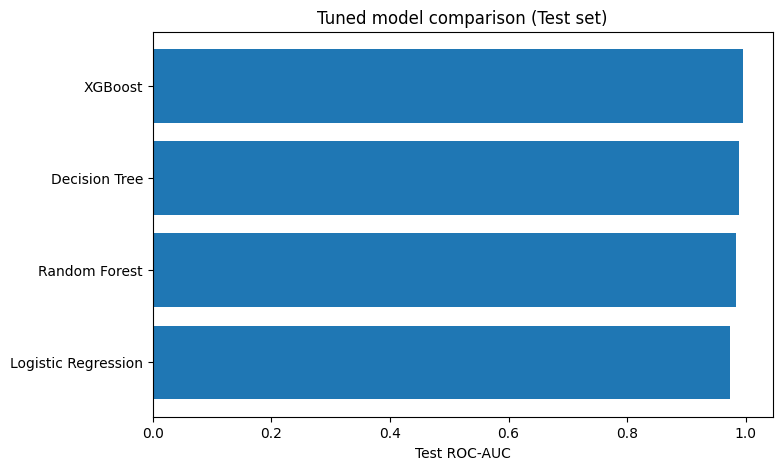

In [56]:
plt.figure(figsize=(8,5))
plt.barh(results_df["Model"], results_df["Test ROC-AUC"])
plt.xlabel("Test ROC-AUC")
plt.title("Tuned model comparison (Test set)")
plt.gca().invert_yaxis()
plt.show()

In [57]:
xgb_model = best_models["XGBoost"].named_steps["clf"]
importances = xgb_model.feature_importances_
feature_names = best_models["XGBoost"].named_steps["prep"].get_feature_names_out()
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

importance_df = importance_df.sort_values(
    by="Importance",
    ascending=False
).head(10)

importance_df

,Feature,Importance
6,hdf,0.2904
8,osf,0.2165
7,pwf,0.2147
5,twf,0.1837
2,rotational_speed_[rpm],0.0569
4,tool_wear_[min],0.0102
3,torque_[nm],0.0089
0,air_temperature_[k],0.0055
11,type_L,0.0046
1,process_temperature_[k],0.0044


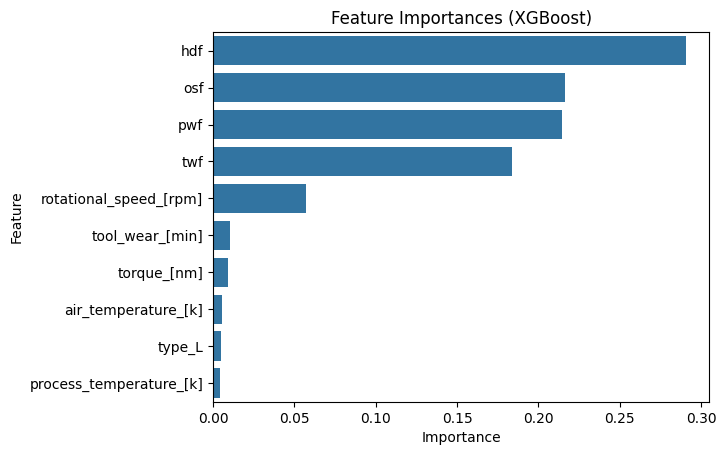

In [58]:
sns.barplot(x="Importance", y="Feature", data=importance_df.sort_values("Importance", ascending=False))
plt.title("Feature Importances (XGBoost)")
plt.show()

In [59]:
len(importances), len(feature_names)

(13, 13)

In [60]:
importance_df.describe()

,Importance
count,10.0000
mean,0.0996
std,0.1132
min,0.0044
25%,0.0064
50%,0.0335
75%,0.2069
max,0.2904


In [62]:
model_filename = 'model.bin'
joblib.dump(best_models["XGBoost"], model_filename)
print(f"✓ Model saved to '{model_filename}'")

✓ Model saved to 'model.bin'


In [63]:
loaded_model = joblib.load(model_filename)
test_prediction = loaded_model.predict(X_test[:5])
print(f"✓ Model loaded successfully. Sample predictions: {test_prediction}")

✓ Model loaded successfully. Sample predictions: [0 0 0 0 0]


In [64]:
# Check what features the model expects
print("Features expected by model:")
print(best_models['XGBoost'].named_steps['prep'].get_feature_names_out())

Features expected by model:
['air_temperature_[k]' 'process_temperature_[k]' 'rotational_speed_[rpm]'
 'torque_[nm]' 'tool_wear_[min]' 'twf' 'hdf' 'pwf' 'osf' 'rnf' 'type_H'
 'type_L' 'type_M']
